# Text Classification: Yelp Reviews

In [1]:
# Imports
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

print("Version: ", tf.__version__)

Version:  2.2.0


In [2]:
'''
Find all available TFDS datasets
'''
# tfds.list_builders()

'\nFind all available TFDS datasets\n'

In [3]:
# Download the Yelp review dataset
# Split the dataset into a train and test set
train_data, validation_data, test_data = tfds.load(
    name="yelp_polarity_reviews",
    split=('train[:60%]', 'train[:60%]', 'test'),
    as_supervised=True)

In [4]:
# Print the first 5 examples and labels
train_examples_batch, train_labels_batch = next(iter(train_data.batch(5)))
# print('Reviews: \n{}\n'.format(train_examples_batch))
# print('Labels: {}'.format(train_labels_batch))
train_examples_batch
# train_labels_batch

<tf.Tensor: shape=(5,), dtype=string, numpy=
array([b"The Groovy P. and I ventured to his old stomping grounds for lunch today.  The '5 and Diner' on 16th St and Colter left me with little to ask for.  Before coming here I had a preconceived notion that 5 & Diners were dirty and nasty. Not the case at all.\\n\\nWe walk in and let the waitress know we want to sit outside (since it's so nice and they had misters).  We get two different servers bringing us stuff (talk about service) and I ask the one waitress for recommendations.  I didn't listen to her, of course, and ordered the Southwestern Burger w/ coleslaw and started with a nice stack of rings.\\n\\nThe Onion Rings were perfectly cooked.  They looked like they were prepackaged, but they were very crispy and I could actually bite through the onion without pulling the entire thing out (don't you hate that?!!!)\\n\\nThe Southwestern Burger was order Medium Rare and was cooked accordingly.  Soft, juicy, and pink with a nice crispy brow

In [5]:
# Use a pre-trained text embedding model to convert sentences into embeddings vectors
# I will use the google/tf2-preview/nnlm-en-dim50/1 model found here:
# https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1
embed_model = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"

In [6]:
# Now create a Keras layer that uses the pre-trained text embedding model to convert sentences into embeddings vectors
embed_layer=hub.KerasLayer(embed_model,
                           input_shape=[],
                           dtype=tf.string,
                           trainable=True)

In [7]:
# Build full model
yelp_model=tf.keras.Sequential()
yelp_model.add(embed_layer) # First layer is going to be the text embedding model
yelp_model.add(tf.keras.layers.Dense(16, activation='relu'))
yelp_model.add(tf.keras.layers.Dense(1))

yelp_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                400020    
_________________________________________________________________
dense (Dense)                (None, 16)                336       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 400,373
Trainable params: 400,373
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Define loss function and optimizer
yelp_model.compile(optimizer='adam', 
                   loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=['accuracy'])

In [9]:
# Train the model
yelp_model_train=yelp_model.fit(train_data.shuffle(1000).batch(258),
                               epochs=5,
                               validation_data=validation_data.batch(258),
                               verbose=1)


Epoch 1/5
1303/1303 [==============================] - 46s 35ms/step - loss: 0.3012 - accuracy: 0.8574 - val_loss: 0.1947 - val_accuracy: 0.9157
Epoch 2/5
1303/1303 [==============================] - 49s 37ms/step - loss: 0.1908 - accuracy: 0.9201 - val_loss: 0.1784 - val_accuracy: 0.9230
Epoch 3/5
1303/1303 [==============================] - 46s 35ms/step - loss: 0.1809 - accuracy: 0.9247 - val_loss: 0.1739 - val_accuracy: 0.9237
Epoch 4/5
1303/1303 [==============================] - 49s 38ms/step - loss: 0.1759 - accuracy: 0.9269 - val_loss: 0.1702 - val_accuracy: 0.9251
Epoch 5/5
1303/1303 [==============================] - 47s 36ms/step - loss: 0.1727 - accuracy: 0.9280 - val_loss: 0.1650 - val_accuracy: 0.9290


In [10]:
# Evaluate the model
results=yelp_model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(yelp_model.metrics_names, results):
  print("%s: %.3f" % (name, value))

75/75 - 2s - loss: 0.1888 - accuracy: 0.9204
loss: 0.189
accuracy: 0.920


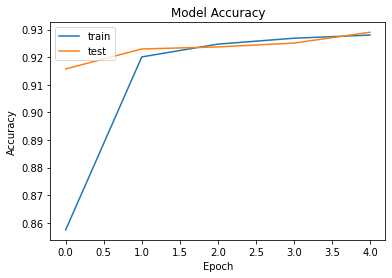

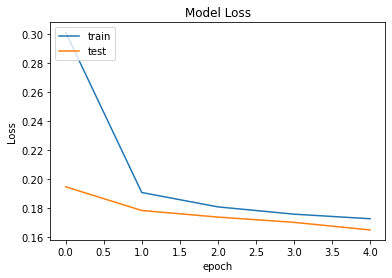

In [11]:
# Summarize history for accuracy
plt.plot(yelp_model_train.history['accuracy'])
plt.plot(yelp_model_train.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Summarize history for loss
plt.plot(yelp_model_train.history['loss'])
plt.plot(yelp_model_train.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()